In [16]:
!pip install spacy
!pip install pandas
!pip install spacytextblob
!pip install bs4
!pip install gensim==3.8.3

In [17]:
!pip install matplotlib
!pip install scipy
!pip install newspaper3k

In [18]:
!python -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 18.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [19]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import pandas as pd
from bs4 import BeautifulSoup
import requests
from newspaper import Article

In [20]:
# For Topic Modeling
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models import FastText

import numpy as np
import os
from random import shuffle
import re
import matplotlib.pyplot as plt 
import numpy as np
import pyLDAvis
import pyLDAvis.gensim

In [21]:
# Loading our two pipelines
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

config = {"punct_chars": [".", "?", "!", "。"]}
nlp.add_pipe('sentencizer')

In [22]:
# Using panda to load in our .csv file
df = pd.read_csv("urls.csv") # File we are checking
urls = df["Address"].tolist() # Column name we are checking
url_sent_score = []
url_sent_label = []
url_subj_score = []
url_subj_label = []
total_pos = []
total_neg = []
topic_sentiment = []

In [23]:
def get_named_entities(doc):
    ent_list = []
    for ent in doc.ents:
        ent_list.append((ent.text,ent.label_))
    return ent_list

def get_sentences(doc):
    return doc.sents

def get_sentence_list(doc):
    return [sent for sent in doc.sents]

#Takes a doc object from spacy and returns a tuple list of form (sentence, sentiment of sentence) for all sentences
def sentence_sentiment_from_doc(doc):
    sentences = get_sentences(doc)
    tuple_list = []
    for sentence in sentences:
        sent_doc = nlp(sentence.text)
        tuple_list.append((sentence.text,sent_doc._.blob.polarity))
    return tuple_list

#Finds all named entities (does not filter by person, date, etc) and returns sentiment value based on the sentences they
#are included in. Returns dictionary of form {entity name : sentiment value}
def sentence_sentiment_on_named_entities(doc):
    named_ent_list = get_named_entities(doc)
    sentence_sentiment_list = sentence_sentiment_from_doc(doc)
    return_dict = {}
    
    for (name, label) in named_ent_list:
        #print(name, "\n")
        #print(type(name))
        return_dict[name] = 0
        
        for (sentence, sentiment) in sentence_sentiment_list:
             if sentence.find(name) != -1:
                    #print(name,sentence)
                    return_dict[name] += sentiment
    
    return return_dict

#takes in a single topic word, the word's weight, and the doc, and returns sentiment of that word within the doc
def sentence_level_sentiment_of_word(word, weight, doc):
    sentence_sentiment_list = sentence_sentiment_from_doc(doc)
    sentiment_total = 0
    
    for (sentence, sentiment) in sentence_sentiment_list:
             if sentence.find(word) != -1:
                    #print(name,sentence)
                    sentiment_total += sentiment
    return sentiment_total

def weighted_word_sentiment(word,weight, doc):
    sentiment = sentence_level_sentiment_of_word(word, weight, doc)
    weighted_sentiment = sentiment * weight
    return weighted_sentiment

In [24]:
#https://pypi.org/project/spacytextblob/
for count, x in enumerate(urls):
    if(count % 10 == 0):
        print(count)
    try:
        url = x
        
        article = Article(url)
        article.download()
        article.parse()
#         headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36'}
#         res = requests.get(url,headers=headers)
#         html_page = res.text

#         soup = BeautifulSoup(html_page, 'html.parser')
#         for script in soup(["script", "style","meta","label","header","footer"]):
#             script.decompose()
#         page_text = (soup.get_text()).lower()
#         page_text = page_text.strip().replace("  ","")
#         page_text = "".join([s for s in page_text.splitlines(True) if s.strip("\r\n")])
        
        page_text = (article.text).lower()
        page_text = page_text.strip().replace("  ","")
        page_text = "".join([s for s in page_text.splitlines(True) if s.strip("\r\n")])
        
        # Start the sentiment analysis now
        doc = nlp(page_text)
        sentiment = doc._.blob.polarity
        sentiment = round(sentiment,2)
        subjectivity = doc._.blob.subjectivity
        subjectivity = round(subjectivity,2)
        
#         if count / 3 == 1:
#             print("enter test spot\n")
#             #ent_list = get_named_entities(doc)
#             #print(ent_list)
#             sentence_sentiment_list = sentence_sentiment_from_doc(doc)
#             #sent_1 = sentence_sentiment_list.pop()
#             #print(sent_1)
#             #print(type(sent_1[0]))
#             print(sentence_sentiment_list)
#             topic_level_sentiment = sentence_sentiment_on_named_entities(doc)
#             #print(topic_level_sentiment)
#             print(sentence_level_sentiment_of_word('kansas',0,doc))
#             break
            
        #print("\n")

        # Gives positive or negative label
        if sentiment >= -0.033 and sentiment <= 0.043:
            sent_label = "Neutral"
        elif sentiment > 0.043 and sentiment < 0.143:
            sent_label = "Neutral Positive"
        elif sentiment > 0.143:
            sent_label = "Positive"
        elif sentiment < -0.033 and sentiment > -0.062:
            sent_label = "Neutral Negative"
        elif sentiment < -0.062:
            sent_label = "Negative"

        #Document's topic-level sentiment assessment of named entities
        topic_level_sentiment = sentence_sentiment_on_named_entities(doc)
        topic_sentiment.append(topic_level_sentiment)
        
        #Adding label, sentiment, subjectivity of document
        url_sent_label.append(sent_label)
        url_sent_score.append(sentiment)
        url_subj_score.append(subjectivity)

        positive_words = []
        negative_words = []

        for x in doc._.blob.sentiment_assessments.assessments:
          if x[1] > 0:
            positive_words.append(x[0][0])
          elif x[1] < 0:
            negative_words.append(x[0][0])
          else:
            pass

        total_pos.append(', '.join(set(positive_words)))
        total_neg.append(', '.join(set(negative_words)))
    except:
        url_sent_label.append("Error")
        url_sent_score.append(0.0)
        url_subj_score.append(0.0)
        topic_sentiment.append({'Error':0})

        positive_words = []
        negative_words = []

        total_pos.append(', '.join(set(positive_words)))
        total_neg.append(', '.join(set(negative_words)))

print("The average sentiment score was: " + str(sum(url_sent_score) / len(url_sent_score)))
print("The average subjectivity score was: " + str(sum(url_subj_score) / len(url_subj_score)))

df["Sentiment Score"] = url_sent_score
df["Sentiment Label"] = url_sent_label
df["Subjectivity Score"] = url_subj_score
df["Positive Words"] = total_pos
df["Negative Words"] = total_neg
df["Topic Sentiment"] = topic_sentiment

df

0
The average sentiment score was: 0.10666666666666669
The average subjectivity score was: 0.41333333333333333


,Address,Sentiment Score,Sentiment Label,Subjectivity Score,Positive Words,Negative Words,Topic Sentiment
0,https://www.nbcnews.com/news/us-news/ohio-dera...,0.13,Neutral Positive,0.43,"very, able, large, more, particular, new, clea...","afraid, little, distant, waste, other","{'east palestine': 0.6363636363636364, 'one': ..."
1,https://www.cnn.com/2023/02/28/health/moderate...,0.17,Positive,0.46,"able, easy, excellent, busy, good, marked, com...","mean, little, difficult, average, active, cent...","{'cnn': 0.7666666666666666, 'seven': 0.5, 'a b..."
2,https://abcnews.go.com/US/chicago-cop-shot-kil...,0.02,Neutral,0.35,"able, large, far, near, striking","down, killed, terrible","{'five years': 0.0, '18-year-old': 0.0, 'thurs..."


In [25]:
# store as list of lists of words
x = get_sentence_list(doc)
input_text = [str(sentence) for sentence in x]

sentences_ted = []
for sent_str in input_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_ted.append(tokens)

stoplist = []
with open('stopwords') as openfileobject:
    for line in openfileobject:
        stoplist.append(line[:-1])
stoplist = set(stoplist)

for i in range(len(sentences_ted)):
    for word in reversed(sentences_ted[i]):
        if word in stoplist:
            sentences_ted[i].remove(word)

dictionary = Dictionary(sentences_ted)
dictionary.filter_extremes(no_below=0.1, no_above=0.9)
bow_corpus = [dictionary.doc2bow(text) for text in sentences_ted]

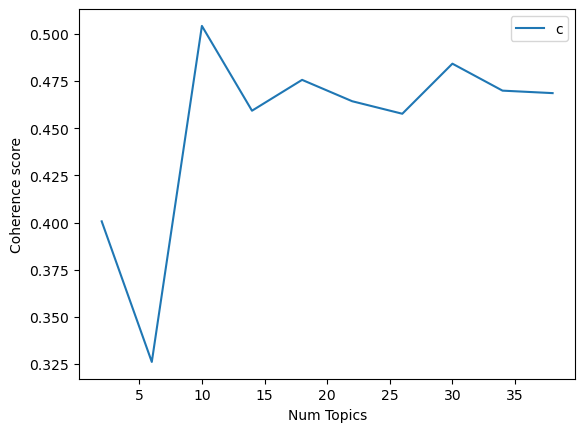

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=sentences_ted, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=sentences_ted, start=2, limit=40, step=4)
# Show graph
limit=40; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score 
of {coherence_values[best_result_index]}''')

The 10 topics gives the highest coherence score 
of 0.5042535590897395


In [28]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(optimal_model, bow_corpus, dictionary)
p

c:\Users\biehl\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.194111  0.089814       1        1  21.327197
2     -0.023008 -0.166958       2        1  14.885051
9      0.083902 -0.019957       3        1  14.601253
6      0.167483  0.092474       4        1  12.754218
7     -0.086021 -0.001350       5        1  12.134052
0     -0.019959  0.056875       6        1   9.692111
8     -0.003501 -0.074909       7        1   6.639876
5      0.027032 -0.016030       8        1   5.965831
1      0.026697  0.020884       9        1   1.227736
4      0.021485  0.019157      10        1   0.772675, topic_info=        Term      Freq     Total Category  logprob  loglift
30      said  6.000000  6.000000  Default   30.000  30.0000
21     brown  5.000000  5.000000  Default   29.000  29.0000
31      shot  5.000000  5.000000  Default   28.000  28.0000
5    vasquez  3.000000  3.000000  Default   27.000  27.0000
3      lasso  3.000000  3.000000  Default   26.000  26.0000
..       ...       ...       ...      ...      ...      ...
21     brown  0.013476  5.587011  Topic10   -5.124  -1.1642
30      said  0.013476  6.479122  Topic10   -5.124  -1.3124
5    vasquez  0.013476  3.859172  Topic10   -5.124  -0.7942
3      lasso  0.013476  3.859174  Topic10   -5.124  -0.7942
76  officers  0.013476  3.175911  Topic10   -5.124  -0.5994

[431 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
53        1  0.696899      1
53        5  0.232300      1
7         6  0.840371     18
54        1  0.696899   2023
54        5  0.232300   2023
...     ...       ...    ...
141       2  0.792430   worn
167       7  0.909503  would
20        6  0.840371   year
6         3  0.513378  years
6         4  0.513378  years

[230 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 10, 7, 8, 1, 9, 6, 2, 5])

In [35]:
for topic_id, topic_words in model_topics:
    print("Topic: " + str(topic_id))
    weighted_topic_sentiment = 0
    word_sentiment_list = []
    for word, weight in topic_words:
        word_sentiment_list.append(weighted_word_sentiment(word, weight, doc))
    for sentiment in word_sentiment_list:
        weighted_topic_sentiment += sentiment
    weighted_topic_sentiment /= len(word_sentiment_list) /100
    print("Topic Words: " + str(topic_words))
    print("Sentiment = " + str(weighted_topic_sentiment))

Topic: 0
Topic Words: [('officer', 0.046875358), ('chicago', 0.046875283), ('day', 0.046875004), ('fatally', 0.024553725), ('range', 0.024553597), ('close', 0.024553597), ('two', 0.024553504), ('exchanged', 0.024553467), ('shooting', 0.024553465), ('old', 0.024553465)]
Sentiment = 0.26451097854546124
Topic: 1
Topic Words: [('tragedy', 0.058510303), ('terrible', 0.0585103), ('police', 0.005319168), ('officer', 0.005319164), ('brown', 0.0053191627), ('chicago', 0.0053191613), ('officers', 0.0053191604), ('shot', 0.005319159), ('said', 0.005319159), ('lasso', 0.005319159)]
Sentiment = -1.0838751930388664
Topic: 2
Topic Words: [('said', 0.06636091), ('police', 0.06629923), ('officer', 0.05017323), ('brown', 0.03400118), ('every', 0.033988215), ('suspect', 0.033963345), ('today', 0.017803242), ('matter', 0.01780324), ('grieving', 0.01780324), ('country', 0.01780324)]
Sentiment = 0.8111822277544034
Topic: 3
Topic Words: [('police', 0.07389799), ('chicago', 0.06126942), ('2023', 0.050290585),